# PyOR also called Python On Resonance
## Author: Vineeth Francis Thalakottoor
## Email: vineeth.thalakottoor@ens.psl.eu or vineethfrancis.physics@gmail.com
## Example: Shape Pulse (Mz as fucntion of frequency)

In [1]:
# Define the source path
SourcePath = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/PyOR_Combined/Source_Doc'

# Add source path
import sys
sys.path.append(SourcePath)
import numpy as np
import time
%matplotlib ipympl

# Import PyOR package
from PyOR_QuantumSystem import QuantumSystem as QunS
from PyOR_Hamiltonian import Hamiltonian
from PyOR_DensityMatrix import DensityMatrix
from PyOR_QuantumObject import QunObj
from PyOR_HardPulse import HardPulse
from PyOR_Basis import Basis
from PyOR_Evolution import Evolutions
from PyOR_Plotting import Plotting
import PyOR_SignalProcessing as Spro

In [2]:
# Define the spin system
Spin_list = {"A" : "H1"}
QS = QunS(Spin_list,PrintDefault=False)

# initialize the system
QS.Initialize()

In [3]:
# Set Parameters

# Master Equation
QS.PropagationSpace = "Hilbert"
QS.MasterEquation = "Redfield"

# B0 Field in Tesla, Static Magnetic field (B0) along Z
QS.B0 = 9.4

# Offset Frequency in rotating frame (Hz)
QS.OFFSET["A"] = 10.0

# Define initial and final Spin Temperature
QS.I_spintemp["A"] = 300.0
QS.F_spintemp["A"] = 300.0

# Relaxation Process
QS.Rprocess = "No Relaxation"

QS.Update()

Rotating frame frequencies: {'A': -2514706800.0}
Offset frequencies: {'A': 10.0}
Initial spin temperatures: {'A': 300.0}
Final spin temperatures: {'A': 300.0}
Radiation damping gain: {'A': 0}
Radiation damping phase: {'A': 0}

Rprocess = No Relaxation
RelaxParDipole_tau = 0.0
DipolePairs = []
RelaxParDipole_bIS = []


In [4]:
# generate Larmor Frequencies
QS.print_Larmor = True
Ham = Hamiltonian(QS)

# Shape file
pulseFile = '/opt/topspin4.1.4/exp/stan/nmr/lists/wave/Rsnob.1000' # Rsnob.1000 or square.1000 or Gaus1.1000
pulseLength = 1000.0e-6 
RotatioAngle = 90.0
t, amp, phase = Ham.ShapedPulse_Bruker(pulseFile,pulseLength,RotatioAngle)

Larmor Frequency in MHz:  [-400.22802765]
Nutation frequency of hard pulse (Hz): 250.0
Scaling Factor: 0.21369571573119997
Maximum nuB1 (Hz): 1169.887749712614
Period corresponding to maximum nuB1 (s): 0.0008547828629247999


/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/PyOR_Combined/Source_Doc/PyOR_Plotting.py:304: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=self.PlotFontSize, frameon=False)


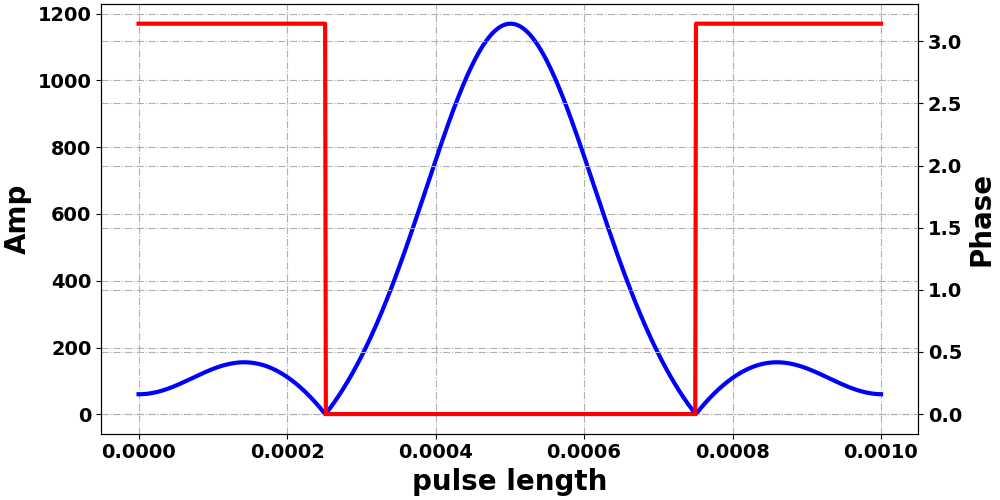

In [5]:
plot = Plotting(QS)
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.PlottingTwin(1,t,amp, phase,"pulse length","Amp","Phase","blue","red")

In [6]:
# Interpolartion
Kind = "previous"
Iamp, Iphase = Ham.ShapedPulse_Interpolate(t,amp,phase,Kind)

In [7]:
# Shape Pulse Parameters

EVol = Evolutions(QS,Ham)


EVol.ShapeFunc = "Bruker"
EVol.ShapeParOmega = Iamp
EVol.ShapeParPhase = Iphase
EVol.ShapeParFreq = 0.0

H_shape = EVol.TimeDependent_Hamiltonian_Hilbert(t)

Larmor Frequency in MHz:  [-400.22802765]


In [8]:
DM = DensityMatrix(QS,Ham)

Thermal_DensMatrix = False

if Thermal_DensMatrix:    
    # High Temperature
    HT_approx = False
    
    # Initial Density Matrix
    rho_in = DM.EquilibriumDensityMatrix(QS.Ispintemp,HT_approx)
    
    # Equlibrium Density Matrix
    rhoeq = DM.EquilibriumDensityMatrix(QS.Fspintemp,HT_approx)
else:
    rho_in = QS.Az 
    rhoeq = QS.Az

In [9]:
# Acquisition parameters
EVol = Evolutions(QS,Ham)

EVol.AcqAQ = pulseLength
Npoints = 1000
EVol.AcqDT = EVol.AcqAQ/Npoints 
EVol.PropagationMethod = "Unitary Propagator Time Dependent"

# Frequency Offset
Foffset = np.arange(0,3000,100)
MXprofile = np.zeros(len(Foffset))  
MYprofile = np.zeros(len(Foffset)) 
MZprofile = np.zeros(len(Foffset)) 

j = 0
for i in Foffset:
    # Offset Frequency in rotating frame (Hz)
    Ham.Offset[0] = i

    # generate Larmor Frequencies
    LarmorF = Ham.LarmorFrequency()

    # Rotating Frame Hamiltonian
    Hz = Ham.Zeeman_RotFrame()
    print(Hz.type)

    start_time = time.time()
    t, rho_t = EVol.Evolution(rho_in,rhoeq,Hz,HamiltonianArray = H_shape)
    print("pass")
    t, Mx1 = EVol.Expectation(rho_t,QS.Ax)
    t, My1 = EVol.Expectation(rho_t,QS.Ay)
    t, Mz1 = EVol.Expectation(rho_t,QS.Az)
    MXprofile[j] =  Mx1[-1].real
    MYprofile[j] =  My1[-1].real
    MZprofile[j] =  Mz1[-1].real
    j = j + 1
    end_time = time.time()
    timetaken = end_time - start_time
    print("Total time = %s seconds " % (timetaken))    

Larmor Frequency in MHz:  [-400.22802765]
Larmor Frequency in MHz:  [-400.22801765]
operator
pass
Total time = 0.14296436309814453 seconds 
Larmor Frequency in MHz:  [-400.22811765]
operator
pass
Total time = 0.12119054794311523 seconds 
Larmor Frequency in MHz:  [-400.22821765]
operator
pass
Total time = 0.09561467170715332 seconds 
Larmor Frequency in MHz:  [-400.22831765]
operator
pass
Total time = 0.07303023338317871 seconds 
Larmor Frequency in MHz:  [-400.22841765]
operator
pass
Total time = 0.07637190818786621 seconds 
Larmor Frequency in MHz:  [-400.22851765]
operator
pass
Total time = 0.07378745079040527 seconds 
Larmor Frequency in MHz:  [-400.22861765]
operator
pass
Total time = 0.07337570190429688 seconds 
Larmor Frequency in MHz:  [-400.22871765]
operator
pass
Total time = 0.07495331764221191 seconds 
Larmor Frequency in MHz:  [-400.22881765]
operator
pass
Total time = 0.07024431228637695 seconds 
Larmor Frequency in MHz:  [-400.22891765]
operator
pass
Total time = 0.06998

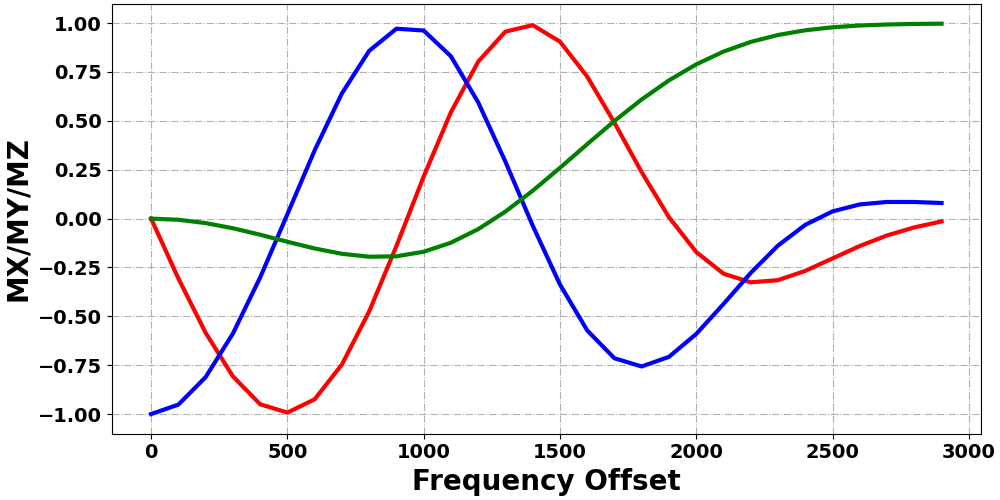

In [10]:
plot = Plotting(QS)
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
fig,span_selector = plot.PlottingMulti_SpanSelector(3,[Foffset,Foffset,Foffset],[2*MXprofile,2*MYprofile,2*MZprofile],"Frequency Offset", "MX/MY/MZ",["red","blue","green"])

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1222: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/opt/anaconda3/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1223: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]


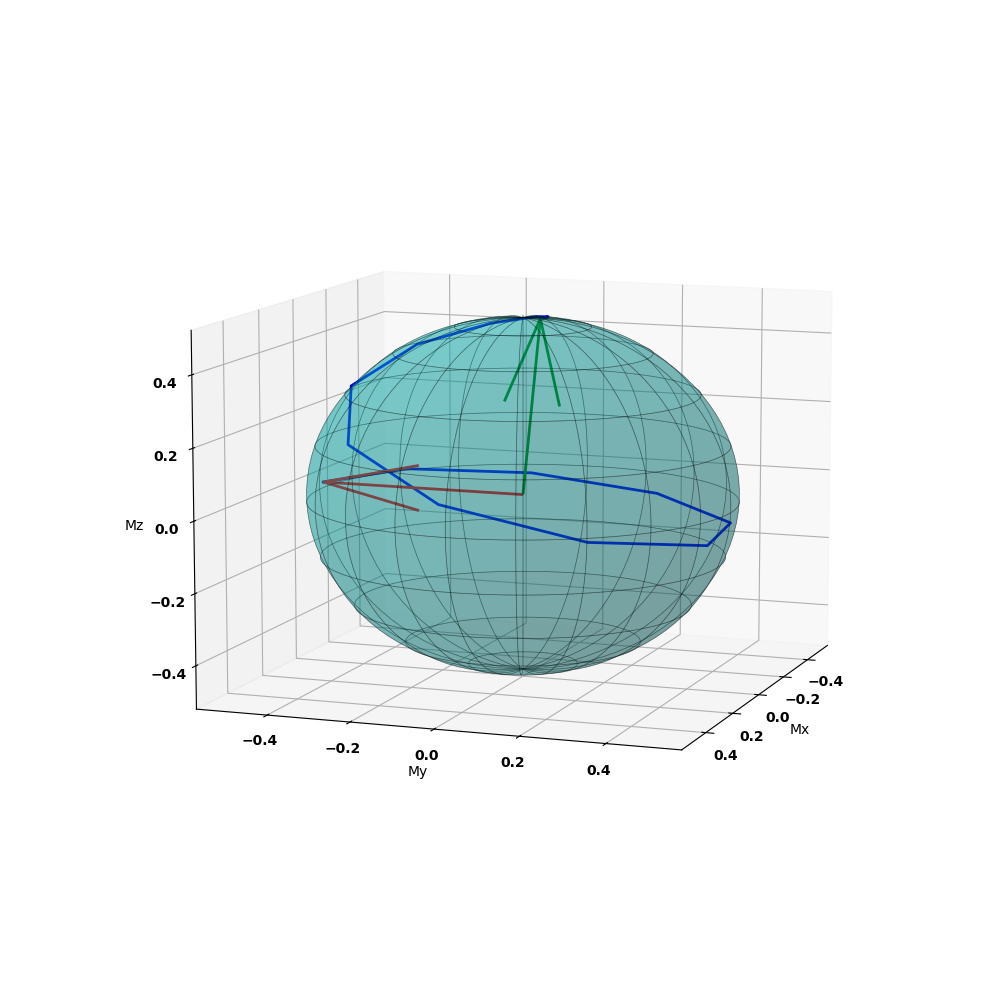

In [11]:
plot.PlotFigureSize = (10,10)
plot.PlotFontSize = 20
plot_vector = False
scale_datapoints = 2
plot.PlottingSphere(5,MXprofile ,MYprofile ,MZprofile ,rhoeq,plot_vector,scale_datapoints)